<a href="https://colab.research.google.com/github/pablohd10/clasificacion-maniobras-conduccion-/blob/main/MANIOBRA_OVERTAKING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

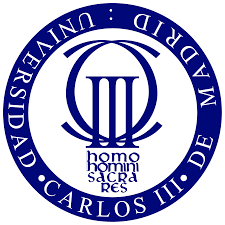

# **PRACTICA 01 - APLICACIONES AVANZADAS DE LA IA**
---
**GRUPO 10**
*   Sergio Caño Amor (100429678)
*   Eduardo Enrique Angulo Luna (100545176)
*   Pablo Hidalgo Delgado (100451225)


## **1. Introducción.**

El objetivo de esta práctica es, a partir del dataset entregado, seleccionar al menos 2 de las 5 maniobras de conducción y determinar qué secuencia de eventos (acciones atómicas) son características de dicha maniobra. En nuestro caso, decidimos utilizar las maniobras de Stopping y Overtaking que corresponden al frenado del vehículo y al adelantamiento a otro vehículo respectivamente. En este notebook, se analizará la maniobra **Overtaking**.

### **1.1 Planteamiento del problema**
Para abordar esta práctica, decidimos desarrollar dos modelos de clasificación basados en **Random Forest** para predecir si un conjunto de datos corresponde a una maniobra específica, en función de las características del comportamiento del conductor. Estos modelos estarán diseñados para clasificar, por separado, las 2 maniobras que se mencionan en la introducción:

- **Frenado del vehículo** (maniobra "Stopping")

- **Adelantamiento** (maniobra "Overtaking").

Al abordar el problema de forma separada para cada maniobra, podremos identificar cuáles son los atributos más relevantes en la toma de decisiones para cada tipo de maniobra.

Dado que los datos son secuenciales, utilizaremos **ventanas temporales** para agrupar la información de instantes pasados en una única instancia, lo que permitirá capturar las dinámicas temporales de cada maniobra. Esta técnica de ventanas deslizantes facilitará que el modelo entienda mejor el contexto temporal de las maniobras, mejorando la precisión del modelo. Se analizará el impacto del tamaño de ventana, tanto solapadas como no solapadas de acuerdo a los resultados del modelo.

Optamos por utilizar Random Forest como el modelo de clasificación debido a su eficiencia, capacidad de manejar datos no lineales y su explicabilidad. Estas características hacen que sea una opción adecuada para nuestro problema, ya que no solo proporcionará buenas predicciones, sino que también nos permitirá interpretar la **importancia de cada atributo** en la clasificación de las maniobras.

## **2. Lectura de los datos.**

En primer lugar, importamos las librerías que necesitaremos a lo largo del proyecto:

In [ ]:
import zipfile
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, recall_score, confusion_matrix
from itertools import product

A continuación, descomprimimos el zip:

In [ ]:
# Ruta al archivo .zip
zip_path = 'ManiobrasSimulador.zip'

extract_path = "./"  # Carpeta donde se extraerán los archivos

# Descomprimimos
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Leemos los datos correspondientes a la **maniobra Overtaking** y los concatenamos en un mismo dataframe de pandas. Añadimos una columna `Driver` que identifica al conductor. Esta columna nos servirá para poder dividir nuestros datos de entrenamiento, validación y test por conductor.

In [ ]:
# Lista de archivos Excel maniobra Overtaking
files_overtaking = ['./ManiobrasSimulador/Driver1/STISIMData_Overtaking.xlsx', './ManiobrasSimulador/Driver2/STISIMData_Overtaking.xlsx', './ManiobrasSimulador/Driver3/STISIMData_Overtaking.xlsx', './ManiobrasSimulador/Driver4/STISIMData_Overtaking.xlsx', './ManiobrasSimulador/Driver5/STISIMData_Overtaking.xlsx']

# Leemos y unimos los datasets
dataframes_overtaking = []
for i, file in enumerate(files_overtaking):
    df = pd.read_excel(file)
    df['Driver'] = i+1  # Añadimos columna de identificación del conductor
    dataframes_overtaking.append(df)

# Concatenamos todos los datos en un único DataFrame
overtaking_data = pd.concat(dataframes_overtaking, ignore_index=True)

## **3. Análisis exploratorio de los datos.**
Antes de empezar con la división en datos de entrenamiento y test, vamos a realizar un análisis exploratorio de datos (`EDA`). De esta manera, podremos investigar y resumir las características más importantes de nuestro conjunto de datos. Esto nos servirá para comprender mejor los datos y optimizar la obtención de nuestro modelo.

### **3.1 Información básica**

In [ ]:
overtaking_data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31557 entries, 0 to 31556
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Elapsed time          31557 non-null  float64
 1   Long Dist             31557 non-null  float64
 2   Lat Pos               31557 non-null  float64
 3   Steering wheel angle  31557 non-null  float64
 4   Throttle input        31557 non-null  float64
 5   Brake pedal force     31557 non-null  float64
 6   Gas pedal             31557 non-null  int64  
 7   Brake pedal           31557 non-null  int64  
 8   Clutch pedal          31557 non-null  int64  
 9   Left turn             31557 non-null  int64  
 10  Right turn            31557 non-null  int64  
 11  Gear                  31557 non-null  int64  
 12  speed                 31557 non-null  float64
 13  RPM                   31557 non-null  float64
 14  Hand wheel torque     31557 non-null  float64
 15  Maneuver marker fla

* El conjunto de datos se compone de **31557 instancias y 24 atributos**, algunos de tipo float64 y otros de tipo int64. La variable de salida, `Maneuver marker flag`, es de tipo int64 (0 si no se está produciendo la maniobra Overtaking y 1 si se está produciendo).

* En este caso, podemos observar que esta maniobra tiene bastantes menos datos (casi la mitad) que la maniobra analizada anteriormente (Stopping): 59286 instancias frente a 31557 instancias.

* También podemos observar que existen 7 columnas que contienen valores nulos. Después de analizar su significado e impacto sobre la variable de salida, decidimos eliminarlas de nuestro dataset ya que no aportan información útil a la variable de respuesta.

In [ ]:
overtaking_data.drop(['Accidents', 'Collisions', 'Peds Hit', 'Speeding Tics', 'Red Lgt Tics', 'Speed Exceed', 'Stop Sign Ticks'], axis=1, inplace=True) # Hay muy pocos valores (solo 5) y no son relevantes para predecir el adelantamiento del vehículo

### **3.2 Atributos compuestos de valores constantes**
A continuación, vamos a comprobar si existen columnas constantes en nuestro conjunto de datos. En ese caso, podremos eliminarlas de nuestro dataset ya que no aportan ninguna información a la variable de respuesta y no existe riesgo de information leakage.

In [ ]:
# Obtenemos las columnas constantes
columnas_constantes = []
for col in overtaking_data.columns:
    if overtaking_data[col].nunique() == 1:
        print(col)
        columnas_constantes.append(col)
if len(columnas_constantes) == 0:
  print("No existen atributos con valores constantes")

No existen atributos con valores constantes


En el caso de la maniobra de adelantamiento, no existen columnas con valores constantes. Sin embargo, en la anterior maniobra analizada, la de parada (Stopping), las columnas de Left turn y Right turn si eran constantes. Esto, tiene sentido, ya que para adelantar a otro coche es necesario girar a la izquierda y luego a la derecha.

### **3.3 Atributos correlados**

A continuación, vamos a estudiar la **correlación** entre los atributos de los datos disponibles. Nos interesa conocer el conjunto de atributos que tienen una correlación especialmente alta (`> 0.95`) entre ellos para así poder determinar cuáles aportan a la variable de respuesta una información extremadamente similar que su par y, en consecuencia, poder plantearnos descartar uno de ellos para reducir la dimensionalidad del problema.


Matriz de correlación. Sólo se muestran valores > 0.95 ó < -0.95

              Elapsed time  Long Dist  Throttle input  Brake pedal force  \
Elapsed time           NaN   0.992133             NaN                NaN   
Long Dist         0.992133        NaN             NaN                NaN   
...                    ...        ...             ...                ...   
Gas pedal              NaN        NaN        0.999958                NaN   
Brake pedal            NaN        NaN             NaN                1.0   

              Gas pedal  Brake pedal  
Elapsed time        NaN          NaN  
Long Dist           NaN          NaN  
...                 ...          ...  
Gas pedal           NaN          NaN  
Brake pedal         NaN          NaN  

[6 rows x 6 columns]


<Axes: >

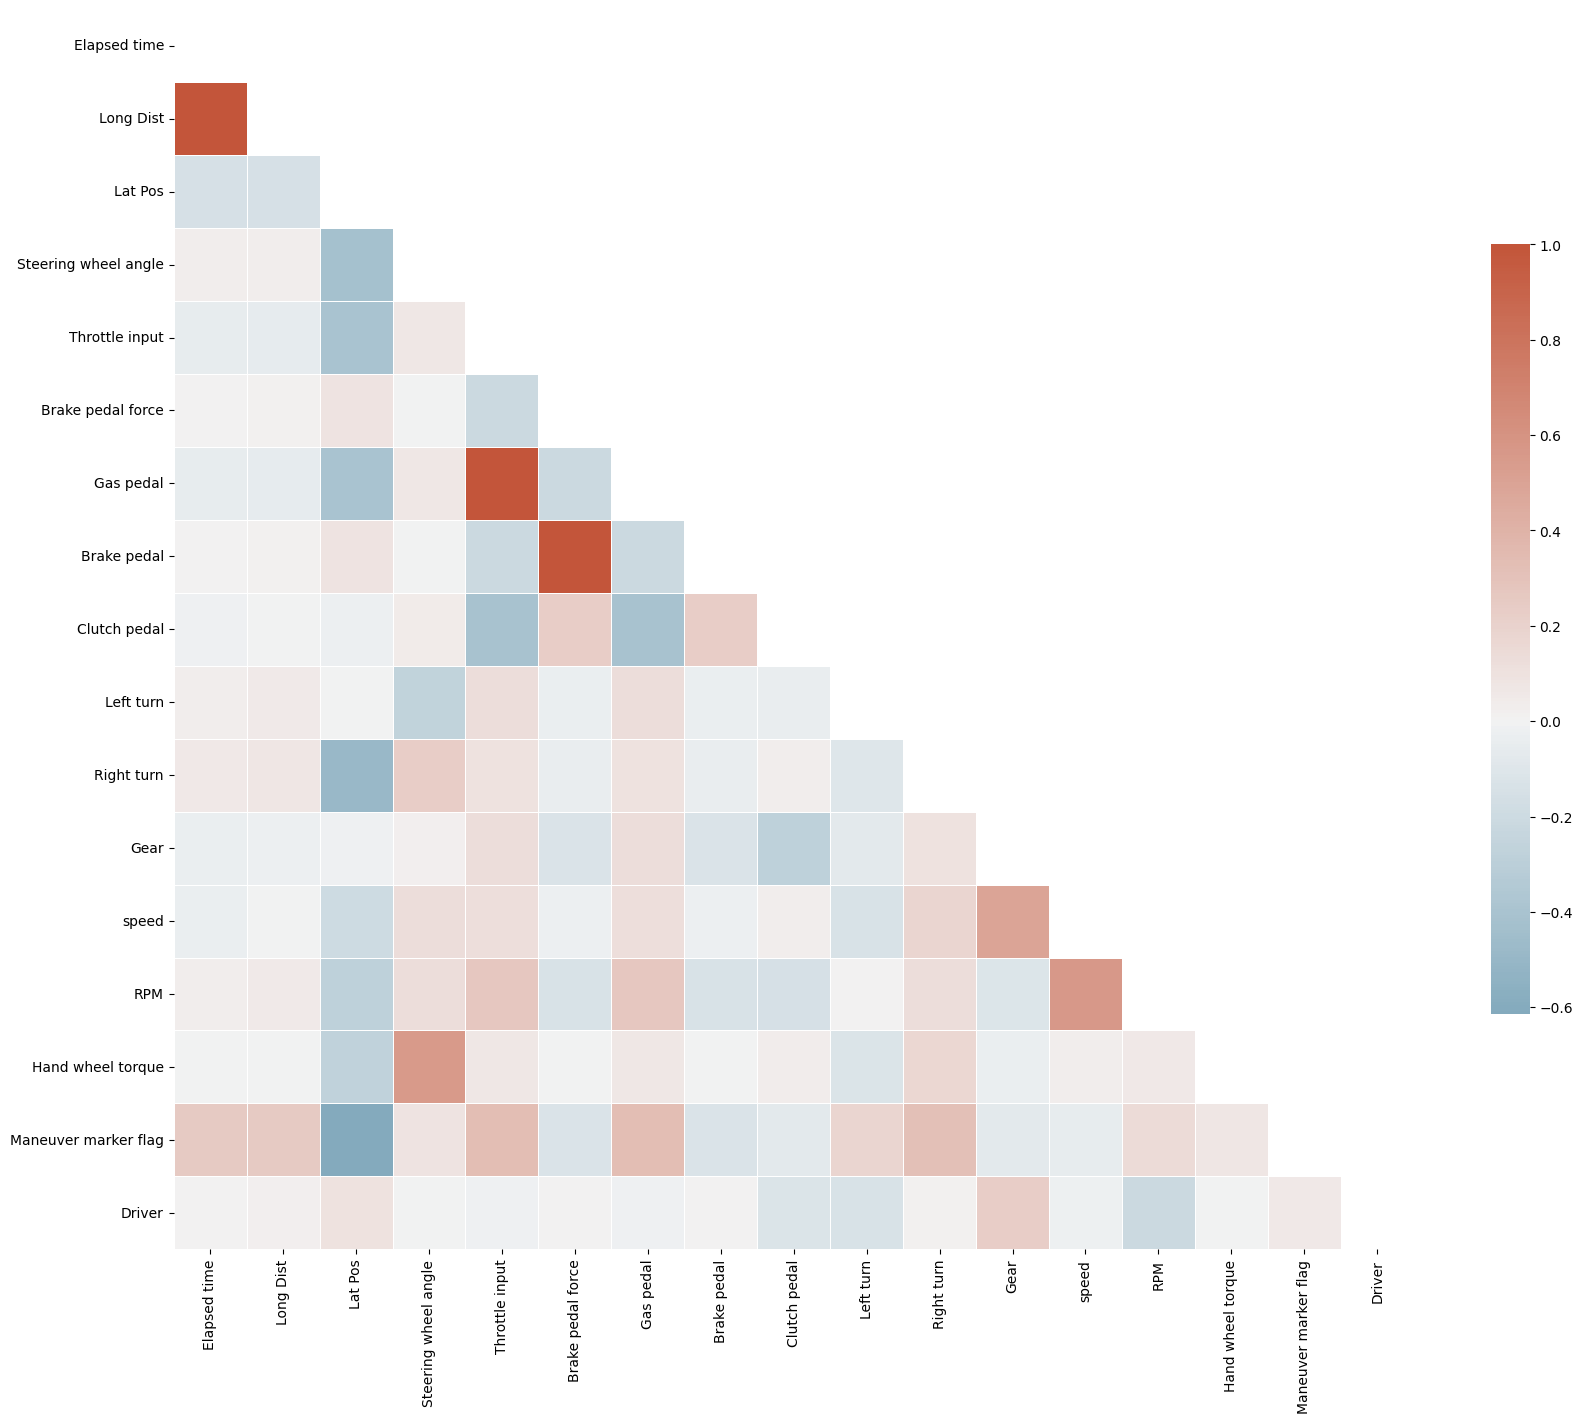

In [ ]:
# Matriz de correlación, sólo se muestran valores > 0.95 ó < -0.95
print("\nMatriz de correlación. Sólo se muestran valores > 0.95 ó < -0.95\n")

# Establecemos el valor máximo de filas a mostrar en 5 para que no ocupe demasiado espacio.
pd.set_option('display.max_rows', 5)

# Calculamos la matriz de correlación (correlación de Pearson)
corr_matrix = overtaking_data.corr()

# Filtramos por los valores que tienen una correlación mayor a 0.95 o menor a -0.95
mask = ((corr_matrix > 0.95) & (corr_matrix < 1)) | ((corr_matrix < -0.95) & (corr_matrix > -1))

# Seleccionamos las columnas y filas que cumplen la condición
high_corr = corr_matrix[mask].dropna(how='all', axis=0).dropna(how='all', axis=1)

# Mostramos las columnas y filas seleccionadas
print(high_corr)

# FIGURA MATRIZ DIAGONAL DE CORRELACION
# Tapamos el triangulo de arriba ya que es innecesario
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Preparamos la figura de matplotlib
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujamos la figura
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Después de analizar la matriz de correlación y los valores obtenidos, identificamos una alta correlación entre las siguientes variables:

- **Long dist y Elapsed time**: Dado que el tiempo transcurrido está directamente relacionado con la distancia recorrida por el vehículo, es esperable que ambas variables presenten una fuerte correlación.

- **Gas pedal y Throttle input**: El atributo `Gas pedal` es el pedal físico que el conductor presiona para controlar la potencia del motor, mientras que la columna `Throttle input` representa la señal enviada al cuerpo del acelerador para regular el flujo de aire, determinada por la posición del pedal. Esta relación inherente explica su alta correlación.

- **Brake pedal y Brake pedal force**: De acuerdo con la descripción del enunciado, el atributo `Brake pedal force` mide la fuerza aplicada por el conductor sobre el pedal, mientras que la columna `Brake pedal` refleja la fuerza de frenado que ejerce el vehículo. En condiciones de pendiente, ambas variables podrían diferir, ya que se requeriría una mayor fuerza para lograr el mismo nivel de frenado. Sin embargo, dado que todas las simulaciones se realizaron en entornos sin pendiente (como se establece en el enunciado de la práctica), la relación entre estas variables es completamente lineal, y lo podemos ver claramente reflejado en la matriz de correlación.

Dado que cada par de variables proporciona información redundante, podemos descartar una de ellas en cada caso sin perder información relevante para el modelo.

In [ ]:
# ELIMINAMOS UNA COLUMNA DE CADA PAR
overtaking_data.drop(['Long Dist'], axis=1, inplace=True)
overtaking_data.drop(['Brake pedal force'], axis=1, inplace=True) #porque no hay pendiente entonces la fuerza que hace el conductor es la misma que el coche internamente
overtaking_data.drop(['Throttle input'], axis=1, inplace=True) #muy correlado con gas pedal --> aportan información similar a la variable de respuesta

### **3.4 Distribución de clases**

En esta sección, analizaremos la distribución de las muestras entre las dos clases posibles: si el vehículo está realizando la maniobra de adelantamiento o no. Para ello, contaremos la cantidad de muestras en cada clase y representaremos los resultados en un gráfico de barras. Este análisis nos permitirá identificar posibles desbalances en los datos que podrían afectar el rendimiento del modelo.

Maneuver marker flag
0    17471
1    14086
Name: count, dtype: int64


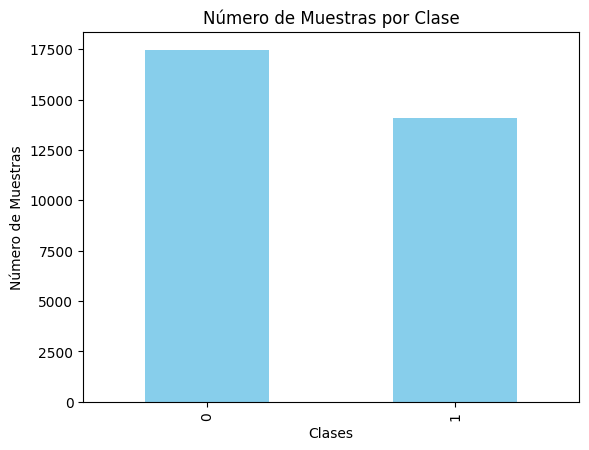

In [ ]:
# Calculamos el recuento de muestras por clase y ordenamos por índice (las clases)
distribucion = overtaking_data['Maneuver marker flag'].value_counts().sort_index()

# Creamos la gráfica de barras
distribucion.plot(kind='bar', color='skyblue')
print(distribucion)
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Número de Muestras por Clase')
plt.show()

Gracias a la gráfica, podemos ver que los datos de la maniobra de adelantamiento no estan significativamente desbalanceados. Lo cual difiere de la maniobra anterior, en la que si se presentaba un desbalanceo significativo. Aunque se puede considerar que las clases ya estan balanceadas, se incluirá el estudio del hiperparámetro de `class_weight='balanced'`, puesto que puede aportar mejores resultados y no supone mucha más carga de cómputo.


## **4. Preproceso de los datos.**
Previamente a entrenar los modelos, debemos realizar una transformación de los datos para que puedan ser interpretados por el algoritmo de manera eficiente. Las transformaciones de datos que realizamos al dataset de adelantamiento son las siguientes:

### **4.1 División de datos en train y test**

Una vez explorado y analizado nuestro conjunto de datos, dividimos el dataset en conjuntos de `entrenamiento` (train) y `prueba` (test). Más tarde, al realizar la validación cruzada, dividiremos el conjunto de entrenamiento en el propio entrenamiento y la validación del mismo (para encontrar los mejores hiperparámetros).

Decidimos dividir los datos de manera que los datos de entrenamiento se correspondan con los 4 primeros conductores, y los datos de test se correspondan con el conductor 5. De esta manera, podremos comprobar cómo el modelo se desempeña con datos de un conductor nunca visto antes.

In [ ]:
train_overtaking_data = overtaking_data[overtaking_data['Driver'].isin([1, 2, 3, 4])]
print("Dimensiones del conjunto de entrenamiento: ", train_overtaking_data.shape)
test_overtaking_data = overtaking_data[overtaking_data['Driver'] == 5]
print("Dimensiones del conjunto de prueba: ", test_overtaking_data.shape)

Dimensiones del conjunto de entrenamiento:  (25374, 14)
Dimensiones del conjunto de prueba:  (6183, 14)


### **4.2 Normalización de los datos**
Es importante normalizar para escalar las características a un mismo rango, evitando que algunas dominen sobre otras y mejorando la estabilidad y rendimiento.

La normalización la realizamos durante la validación cruzada utilizando solo la información de los datos de entrenamiento en cada fold, evitando así el riesgo de `information leakage` y asegurando una evaluación más realista del modelo. Hacemos esto, puesto que si normalizasemos todos los datos antes de separarlos en datos de entrenamiento y test, estaríamos proporcionando una pequeña cantidad de información al modelo sobre los datos de test, cosa que no queremos que suceda.

### **4.3 Creación del conjunto de datos aplicando ventanas deslizantes**

Dado que nuestros datos tienen una **estructura temporal**, utilizamos **ventanas deslizantes** para capturar las dependencias a lo largo del tiempo y permitir que el modelo aprenda cómo los valores previos influyen en los posteriores. Para ello, transformamos los datos de manera que cada ventana se represente como una única fila, donde cada columna almacena los valores de un instante de tiempo dentro de la ventana. Esto proporciona al modelo un contexto más amplio de temporabilidad en lugar de evaluar instantes aislados.

Además, para enriquecer la representación de los datos, calculamos **características agregadas** dentro de cada ventana, como la `media`, la `desviación estándar`, el `valor máximo` y el `mínimo` de cada atributo. Estas características ayudan a capturar patrones más complejos en la evolución de los datos.

En cuanto a la variable de respuesta, definimos que una ventana se considera positiva (1, maniobra en curso) si al menos un instante dentro de ella tiene un 1 en la variable objetivo. Este criterio permite que el modelo aprenda a detectar situaciones previas al inicio del frenado (aunque identificadas como frenado), lo que resulta fundamental para mejorar su capacidad predictiva.

Para implementar este enfoque, desarrollamos la siguiente función que convierte los datos en ventanas deslizantes, permitiendo **ajustar** tanto la **duración de la ventana en segundos** como el **grado de solapamiento** entre ellas. De esta manera, logramos capturar mejor la dinámica temporal del problema y proporcionar al modelo una representación más completa de la secuencia de eventos.

In [ ]:
def generate_sliding_windows(df, window_seconds, overlap_seconds):
    window_size = window_seconds * 20  # 20 filas por segundo
    step = (window_seconds - overlap_seconds) * 20  # Definimos paso según solapamiento

    feature_columns = df.columns.difference(['Driver', 'Maneuver marker flag'])
    windows = []

    for driver_id, driver_data in df.groupby('Driver'): # Para cada conductor
        driver_data = driver_data.reset_index(drop=True)

        for start in range(0, len(driver_data) - window_size + 1, step): # Se crea la ventana deslizante
            window = driver_data.iloc[start:start + window_size]
            features = {}

            # Extraemos las características de la ventana con referencia temporal
            for col in feature_columns:
                features[f'{col}_mean_{window_seconds}s'] = window[col].mean()
                features[f'{col}_std_{window_seconds}s'] = window[col].std()
                features[f'{col}_max_{window_seconds}s'] = window[col].max()
                features[f'{col}_min_{window_seconds}s'] = window[col].min()

                 # Creamos una columna separada por cada instante de tiempo dentro de la ventana
                for i, value in enumerate(window[col].values):
                    features[f'{col}_t{i}'] = value  # Se almacena el valor en una columna específica

            # Etiqueta de la ventana (1 si hay stopping en la ventana, 0 si no)
            features['Maneuver_marker'] = int(window['Maneuver marker flag'].max() > 0)
            features['Driver'] = driver_id  # Mantenemos el identificador del conductor

            windows.append(features)

    return pd.DataFrame(windows)

Generamos varios datasets con los datos correspondientes a las ventanas deslizantes con distintos valores de tamaño de ventana y solapamiento, para así poder diferenciar cual de las divisiones da mejores resultados.

**Ventanas sin solapamiento**
- window_seconds = 10s , overlap_seconds = 0s
- window_seconds = 5s , overlap_seconds = 0s
- window_seconds = 3s , overlap_seconds = 0s
- window_seconds = 1s , overlap_seconds = 0s

**Ventanas solapadas**
- window_seconds = 10s , overlap_seconds = 3s
- window_seconds = 5s , overlap_seconds = 2s
- window_seconds = 3s , overlap_seconds = 1s

In [ ]:
# Ventanas sin solapamiento
train_overtaking_data_window_10s = generate_sliding_windows(train_overtaking_data, window_seconds=10, overlap_seconds=0)
train_overtaking_data_window_5s = generate_sliding_windows(train_overtaking_data, window_seconds=5, overlap_seconds=0)
train_overtaking_data_window_3s = generate_sliding_windows(train_overtaking_data, window_seconds=3, overlap_seconds=0)
train_overtaking_data_window_1s = generate_sliding_windows(train_overtaking_data, window_seconds=1, overlap_seconds=0)

# Ventanas solapadas
train_overtaking_data_window_10s_overlapped = generate_sliding_windows(train_overtaking_data, window_seconds=10, overlap_seconds=3)
train_overtaking_data_window_5s_overlapped = generate_sliding_windows(train_overtaking_data, window_seconds=5, overlap_seconds=2)
train_overtaking_data_window_3s_overlapped = generate_sliding_windows(train_overtaking_data, window_seconds=3, overlap_seconds=1)

# Imprimimos tamaños de los datasets
print("Tamaño de los datasets con ventanas sin solapamiento:")
print(f"Ventanas de 10 segundos: {train_overtaking_data_window_10s.shape}")
print(f"Ventanas de 5 segundos: {train_overtaking_data_window_5s.shape}")
print(f"Ventanas de 3 segundos: {train_overtaking_data_window_3s.shape}")
print(f"Ventanas de 1 segundo: {train_overtaking_data_window_1s.shape}")
print('\n')

print("Tamaño de los datasets con ventanas solapadas:")
print(f"Ventanas de 10 segundos (con solapamiento de 3 segundos): {train_overtaking_data_window_10s_overlapped.shape}")
print(f"Ventanas de 5 segundos (con solapamiento de 2 segundos): {train_overtaking_data_window_5s_overlapped.shape}")
print(f"Ventanas de 3 segundos (con solapamiento de 1 segundo): {train_overtaking_data_window_3s_overlapped.shape}")

Tamaño de los datasets con ventanas sin solapamiento:
Ventanas de 10 segundos: (125, 2450)
Ventanas de 5 segundos: (252, 1250)
Ventanas de 3 segundos: (421, 770)
Ventanas de 1 segundo: (1267, 290)


Tamaño de los datasets con ventanas solapadas:
Ventanas de 10 segundos (con solapamiento de 3 segundos): (178, 2450)
Ventanas de 5 segundos (con solapamiento de 2 segundos): (418, 1250)
Ventanas de 3 segundos (con solapamiento de 1 segundo): (631, 770)


A continuación, verificaremos las columnas que se están generando. Por ejemplo, utilizaremos el conjunto de datos con una ventana de 5 segundos y sin solapamiento.

Dado que cada fila del conjunto de datos representa un intervalo de 0.05 segundos (1 segundo dividido en 20 filas), una ventana de 5 segundos correspondería a 100 filas (5 segundos * 20 filas/segundo). Por lo tanto, deberíamos tener un total de **100 columnas para cada atributo**, representando los diferentes instantes dentro de la ventana, además de las **características agregadas** como la media o el valor máximo de esa ventana

In [ ]:
print(f"Dimensiones de las ventanas de 5 segundos: {train_overtaking_data_window_5s.shape}")
print("Nombres y valores de las primeras filas de varias columnas: \n\n", train_overtaking_data_window_5s.head())
print("Columnas creadas:")
for col in train_overtaking_data_window_5s.columns:
    print(col)

Dimensiones de las ventanas de 5 segundos: (252, 1250)
Nombres y valores de las primeras filas de varias columnas: 

    Brake pedal_mean_5s  Brake pedal_std_5s  Brake pedal_max_5s  \
0                  0.0                 0.0                   0   
1                  0.0                 0.0                   0   
2                  0.0                 0.0                   0   
3                  0.0                 0.0                   0   
4                  0.0                 0.0                   0   

   Brake pedal_min_5s  Brake pedal_t0  Brake pedal_t1  Brake pedal_t2  \
0                   0               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   

   Brake pedal_t3  Brake pedal_t4  Brake pedal

## **5. Validación cruzada y selección de hiperparámetros**


A continuación, exploraremos diversas combinaciones de hiperparámetros y aplicaremos **validación cruzada** para seleccionar la mejor configuración. La validación se llevará a cabo utilizando un esquema en el que el conjunto de entrenamiento se divide en `4 folds`, cada uno correspondiente a los datos de un conductor distinto. En cada iteración, el modelo se entrenará con los datos de 3 conductores y se evaluará con el conductor restante, asegurando así una evaluación más robusta y realista.

Una vez realizados los `folds` y antes de realizar el entrenamiento, eliminamos el identificador del conductor para evitar que el modelo pueda hacer una asociación directa entre las características de conducción y el conductor específico, garantizando que el modelo generalice bien y no esté sesgado por las identidades de los conductores.

Elegimos **RandomForest** como modelo debido a su explicabilidad, sencillez y porque creemos que se adecúa perfectamente al propósito de nuestro problema.

In [ ]:
# Fijamos una semilla aleatoria para reproducibilidad
np.random.seed(42)
random.seed(42)

# Lista de datasets a evaluar
datasets = {
    "window_10s": train_overtaking_data_window_10s,
    "window_5s": train_overtaking_data_window_5s,
    "window_3s": train_overtaking_data_window_3s,
    "window_1s": train_overtaking_data_window_1s,
    "window_10s_overlapped": train_overtaking_data_window_10s_overlapped,
    "window_5s_overlapped": train_overtaking_data_window_5s_overlapped,
    "window_3s_overlapped": train_overtaking_data_window_3s_overlapped
}

# Definimos los hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

# Genera todas las combinaciones de hiperparámetros
param_combinations = list(product(param_grid['n_estimators'], param_grid['max_depth'],
                                  param_grid['min_samples_split'], param_grid['min_samples_leaf'],
                                  param_grid['class_weight']))

# Diccionario para almacenar los mejores resultados por dataset
best_results = {}

# Iteramos sobre cada dataset
total_datasets = len(datasets)
for dataset_name, dataset in datasets.items():
    print(f'\nEvaluando dataset: {dataset_name}')

    best_score = 0
    best_params = None

    # Iteramos sobre cada combinación de hiperparámetros
    for params in param_combinations:
        n_estimators, max_depth, min_samples_split, min_samples_leaf, class_weight = params

        # Obtenemos la lista de conductores únicos del conjunto de entrenamiento
        drivers = dataset['Driver'].unique()

        # Almacenar métricas de validación cruzada
        fold_accuracies = []
        fold_precisions = []
        fold_recalls = []
        fold_f1s = []

        for test_driver in drivers:
            # Separamos datos en train y validación según el conductor
            train_data = dataset[dataset['Driver'] != test_driver]
            val_data = dataset[dataset['Driver'] == test_driver]

            # Separamos características y etiquetas
            X_train = train_data.drop(columns=['Maneuver_marker', 'Driver'])
            y_train = train_data['Maneuver_marker']
            X_val = val_data.drop(columns=['Maneuver_marker', 'Driver'])
            y_val = val_data['Maneuver_marker']

            # Normalizamos SOLO los datos de entrenamiento
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

            # Entrenamos el modelo con los hiperparámetros actuales
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                           min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                           class_weight=class_weight)
            model.fit(X_train, y_train)

            # Realizamos predicciones
            y_pred = model.predict(X_val)

            # Calculamos métricas
            fold_accuracies.append(accuracy_score(y_val, y_pred))
            fold_precisions.append(precision_score(y_val, y_pred, average=None))  # Por clase
            fold_recalls.append(recall_score(y_val, y_pred, average=None))
            fold_f1s.append(f1_score(y_val, y_pred, average=None))

        # Promediamos las métricas de cada fold
        mean_accuracy = np.mean(fold_accuracies)
        mean_precision = np.mean(fold_precisions, axis=0)  # Promedio por clase
        mean_recall = np.mean(fold_recalls, axis=0)
        mean_f1 = np.mean(fold_f1s, axis=0)

        print(f'\nHiperparámetros: {params}')
        print(f'Accuracy: {mean_accuracy:.4f}, '
              f'Precisión por clase: {mean_precision}, '
              f'Recall por clase: {mean_recall}, '
              f'F1 por clase: {mean_f1}')

        # Guardamos el mejor modelo basado en F1-score promedio
        if np.mean(mean_f1) > best_score:
            best_score = np.mean(mean_f1)  # Usamos el promedio de F1 por clase
            best_params = params

    # Almacenamos el mejor resultado para este dataset
    best_results[dataset_name] = {'best_params': best_params, 'best_score': best_score}
    print(f'\nMejores hiperparámetros para {dataset_name}: {best_params}, Mejor F1 promedio: {best_score:.4f}')

# Mostramos el resumen final de los mejores hiperparámetros por dataset
print('\nResumen de los mejores hiperparámetros por dataset:')
for dataset_name, result in best_results.items():
    print(f'{dataset_name}: {result}')


Evaluando dataset: window_10s

Hiperparámetros: (50, None, 2, 1, None)
Accuracy: 0.7766, Precisión por clase: [0.63782051 0.86094862], Recall por clase: [0.6719697  0.81948758], F1 por clase: [0.6375     0.83385093]

Hiperparámetros: (50, None, 2, 1, 'balanced')
Accuracy: 0.7882, Precisión por clase: [0.68333333 0.84121377], Recall por clase: [0.64924242 0.84865424], F1 por clase: [0.66039216 0.8432971 ]

Hiperparámetros: (50, None, 2, 2, None)
Accuracy: 0.7781, Precisión por clase: [0.70039683 0.82244048], Recall por clase: [0.5969697  0.85744048], F1 por clase: [0.63648325 0.83738145]

Hiperparámetros: (50, None, 2, 2, 'balanced')
Accuracy: 0.7813, Precisión por clase: [0.73333333 0.82059524], Recall por clase: [0.58257576 0.86160714], F1 por clase: [0.63876518 0.83773478]

Hiperparámetros: (50, None, 5, 1, None)
Accuracy: 0.7099, Precisión por clase: [0.5782967  0.83317084], Recall por clase: [0.6469697  0.73198758], F1 por clase: [0.58266129 0.75749625]

Hiperparámetros: (50, None

Para cada modelo generado durante la validación cruzada, obtenemos métricas como: `accuracy`, `precisión`, `recall` y `f1-score`. La métrica utilizada para seleccionar el mejor modelo es el **f1-score**, ya que combina tanto la precisión como el recall, proporcionando una evaluación más equilibrada del rendimiento del modelo en este tipo de problemas.

## **6. Construcción del mejor modelo y evaluación sobre el conjunto de test**

Basándonos en los resultados obtenidos durante la validación cruzada, el mejor modelo (mayor f-score) es el que consta de los siguientes hiperparámetros:

- **n_estimators**: 50

- **max_depth**: None

- **min_sample_split**: 5

- **min_samples_leaf**: 1

- **class_weight**: None

Además, los mejores resultados son los que utilizan una **ventana de 1 segundo sin solapamiento.**

Para evaluar nuestro modelo con los datos de prueba, es necesario que estos también estén transformados en ventanas temporales. Por ello, generamos el conjunto de datos de prueba utilizando ventanas deslizantes de 1 segundo sin solapamiento.

In [ ]:
test_overtaking_data_window = generate_sliding_windows(test_overtaking_data, window_seconds=1, overlap_seconds=0)

Entrenamos el modelo con todos los datos de entrenamiento (los 4 conductores) y lo evaluamos con los datos de prueba (el conductor número 5).

In [ ]:
# Separamos características y etiquetas
X_train = train_overtaking_data_window_1s.drop(columns=['Maneuver_marker', 'Driver'])
y_train = train_overtaking_data_window_1s['Maneuver_marker']
X_test = test_overtaking_data_window.drop(columns=['Maneuver_marker', 'Driver'])
y_test = test_overtaking_data_window ['Maneuver_marker']

# Guardamos los nombres de las características antes de la normalización
feature_names = X_train.columns

# Normalizamos SOLO con datos de entrenamiento
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entrenamos el modelo con los hiperparámetros actuales
model = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=5, min_samples_leaf=1, class_weight=None)
model.fit(X_train, y_train)

# Realizamos predicciones
y_pred = model.predict(X_test)
# Calculamos métricas
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred, average=None))  # Por clase
print("Recall: ", recall_score(y_test, y_pred, average=None))
print("F1_score: ", f1_score(y_test, y_pred, average=None))

Accuracy:  0.8543689320388349
Precision:  [0.75722543 0.97794118]
Recall:  [0.97761194 0.76      ]
F1_score:  [0.8534202  0.85530547]


## **7. Análisis de resultados**

Analizando los resultados obtenidos, el modelo de clasificación consigue un **accuracy** del **85.4%**, lo que indica un desempeño sólido en la tarea de clasificación de la maniobra de adelantamiento.

Analizando las métricas por clase, la **precisión** es notablemente alta para la clase Adelantamiento (97.8%), lo que significa que cuando el modelo predice un adelantamiento, casi siempre es correcto. Sin embargo, en la clase No-Adelantamiento, la precisión es menor (75.7%), lo que sugiere que algunas instancias de esta clase están siendo clasificadas erróneamente como adelantamientos.

En términos de **recall**, ocurre lo contrario: el modelo detecta casi todos los casos de No-Adelantamiento (97.8%), pero es menos efectivo en identificar todos los adelantamientos reales, con un recall del 76%. Esto indica que el modelo tiende a favorecer la detección de la clase "No-Adelantamiento", pero puede estar omitiendo algunos adelantamientos reales.

El **f1-score**, que equilibra precisión y recall, es similar para ambas clases (≈85.5%), lo que sugiere un desempeño equilibrado.

Todo esto lo podemos observar más claramente en la siguiente matriz de confusión:

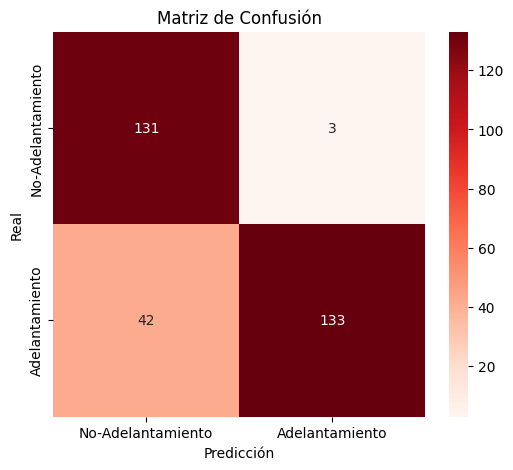

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["No-Adelantamiento", "Adelantamiento"], yticklabels=["No-Adelantamiento", "Adelantamiento"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

### **7.1 Explicabilidad del modelo**

El modelo RandomForest nos permite investigar la **relevancia de las características** utilizadas en el proceso de toma de decisiones, mediante el cálculo de la importancia de los atributos.

Este cálculo se realiza de manera interna, utilizando un criterio heurístico que selecciona los atributos que contribuyen más a la reducción de la **entropía** a lo largo de los árboles del bosque (estos atributos pueden aparecer en diferentes ubicaciones dentro de un mismo árbol o en distintos árboles).

Es importante destacar que la importancia asignada a un atributo refleja su utilidad para el modelo, pero no necesariamente significa que los atributos con menor importancia no sean relevantes para el problema en sí.

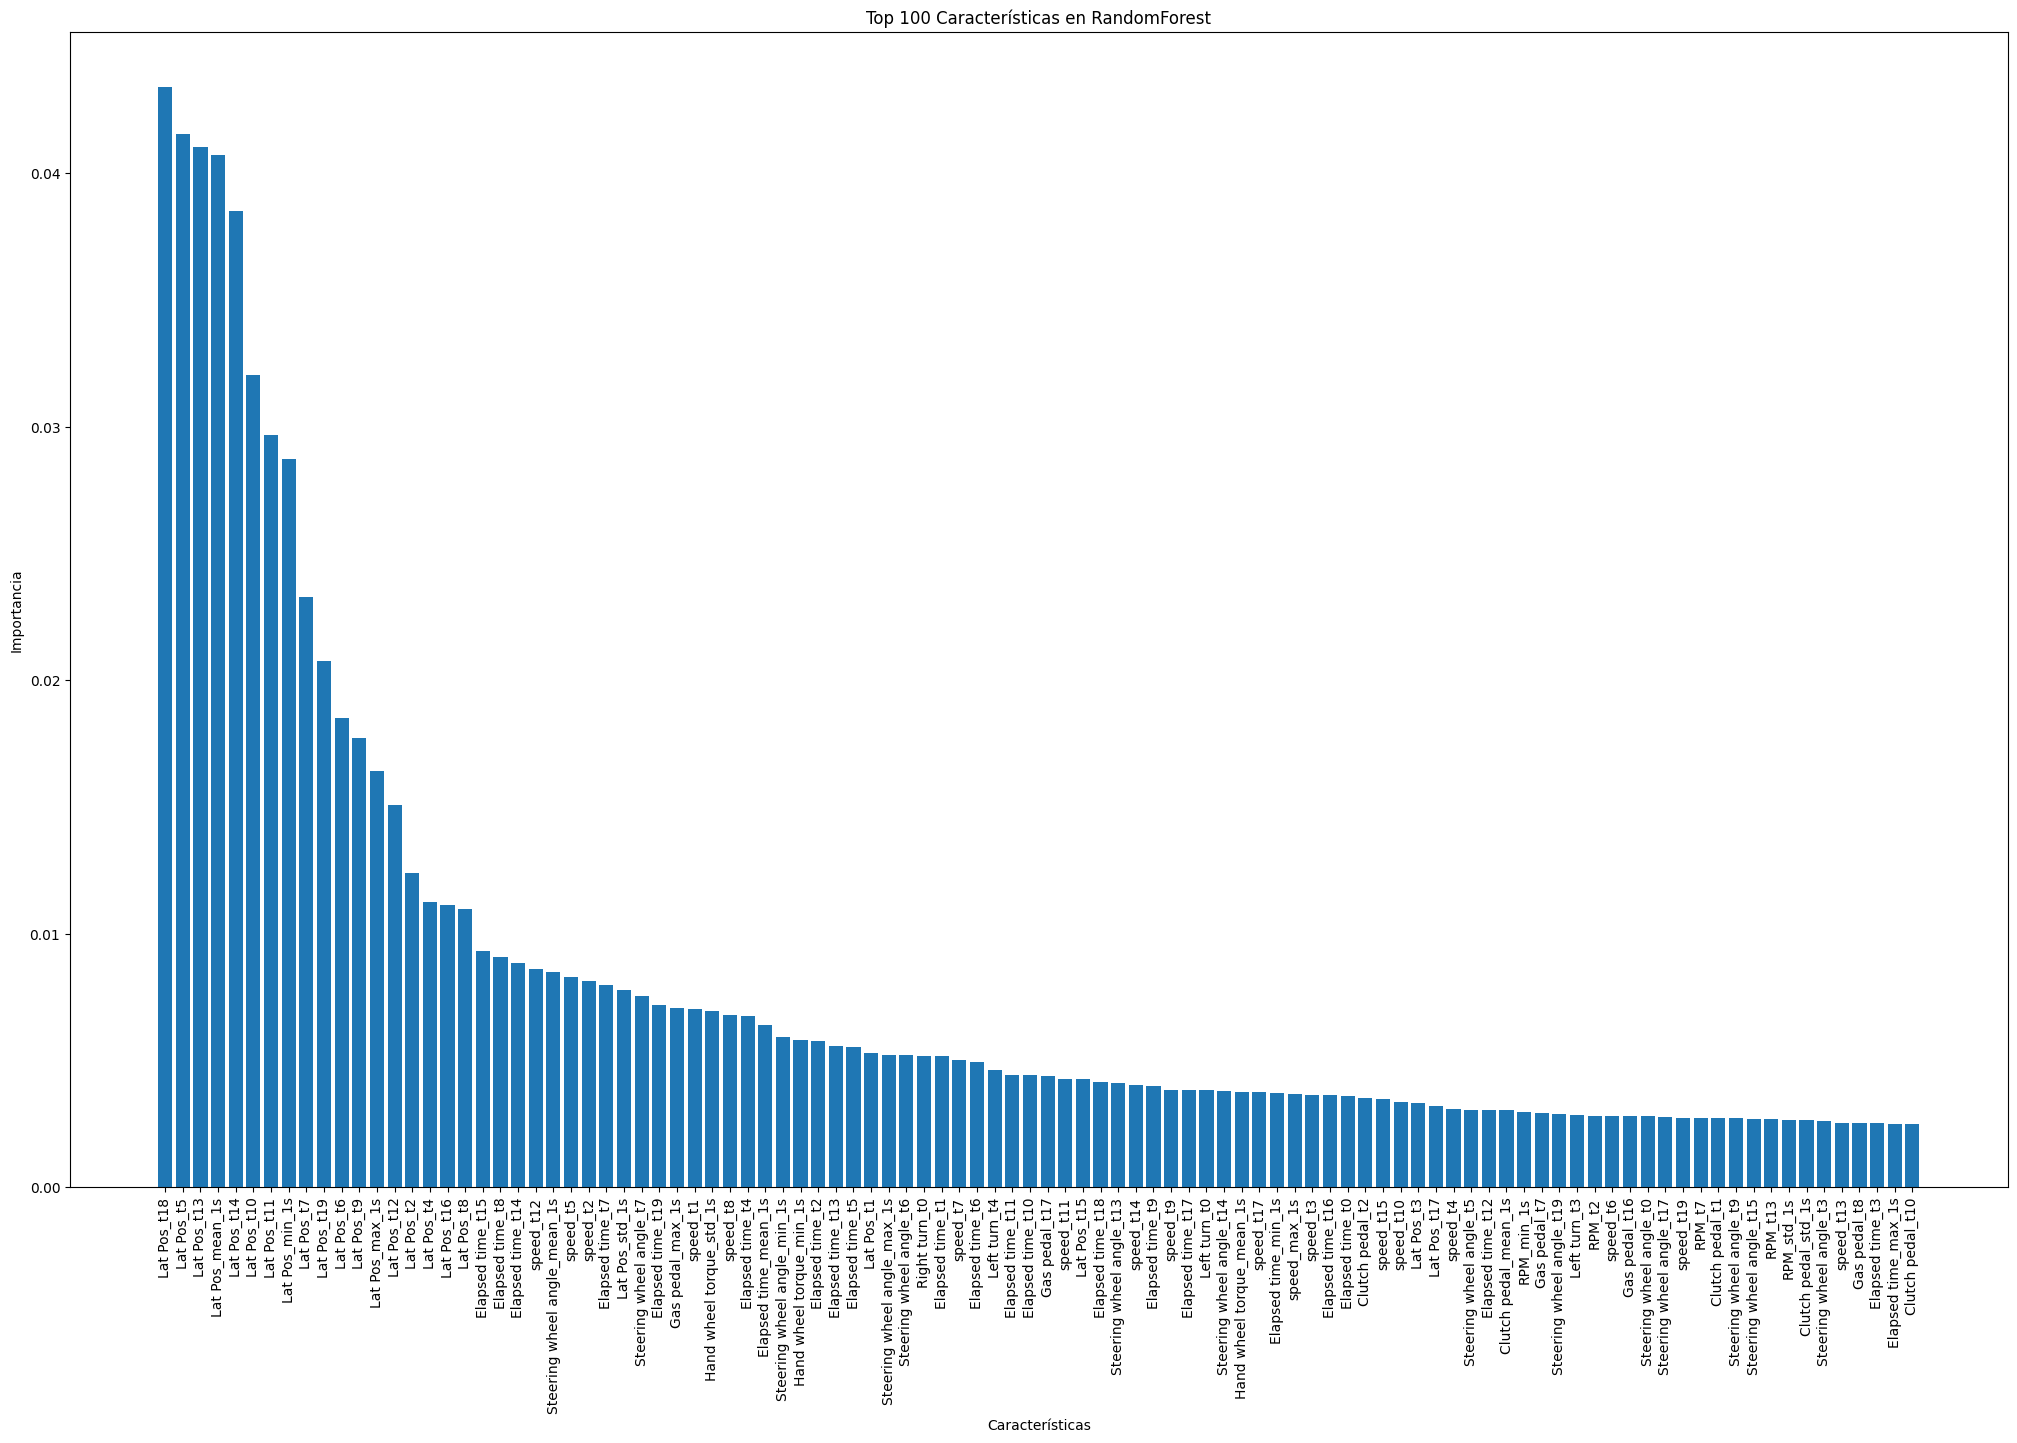

In [ ]:
# Convertimos X_train a DataFrame después de la normalización
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Ahora podemos acceder a las columnas de forma correcta
importances = model.feature_importances_
feature_names = X_train_df.columns

# Ordenar características por importancia
sorted_indices = np.argsort(importances)[::-1]

# Limitar a las 100 características más importantes
top_n = 100
sorted_indices = sorted_indices[:top_n]
importances_top = importances[sorted_indices]
feature_names_top = [feature_names[i] for i in sorted_indices]

# Crear la gráfica
plt.figure(figsize=(25, 15))
plt.bar(range(top_n), importances_top, align="center")
plt.xticks(range(top_n), feature_names_top, rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title(f"Top {top_n} Características en RandomForest")
plt.show()

La gráfica muestra la importancia relativa de las **100 características más relevantes** en el modelo RandomForest utilizado para la clasificación de la **maniobra de adelantamiento**. Se observa que la característica más influyente es **Lat Pos**, destacándose significativamente sobre el resto, lo que indica que la posición del coche en el último segundo es muy influyente para clasificar la maniobra de adelantamiento. Esto puede deberse a que, dado que el adelantamiento se hace por la izquierda, el vehículo debe desplazarse al carril izquierdo y por tanto el valor de esta variable cambia con respecto a si el vehículo se encuentra en el carril derecho.

Además de la posición lateral, otras variables relacionadas con la dirección, como Steering wheel angle, tienen importancia en el modelo, lo que refleja la necesidad de realizar un giro del volante al adelantar.

Otras variables, como la velocidad (Speed), el pedal del gas (Gas pedal) y el pedal del embrague (Clutch pedal), tienen menor peso en la clasificación pero siguen aportando información valiosa. En general, la distribución de importancia muestra que el modelo se basa en una combinación de factores espaciales, temporales y de control del vehículo para predecir con precisión las maniobras de adelantamiento.

## **8. Comparación entre ambos modelos (Stopping y Overtaking)**
A continuación, se analizarán y compararán los dos modelos desarrollados, cada uno diseñado para clasificar una maniobra específica:

1. **Rendimiento General**
  - El modelo de frenado obtuvo un mejor rendimiento global en comparación con el modelo de adelantamiento. Su mejor configuración alcanzó un f1-score de 0.9202 y una exactitud del 92.17%, mientras que el modelo de adelantamiento logró un f1-score de 0.8408 y una exactitud del 85.4%.

  - Esto sugiere que la maniobra de frenado es más fácil de clasificar con las características disponibles en los datos, posiblemente debido a que el frenado genera patrones más evidentes en variables como el pedal del acelerador y el freno, mientras que la maniobra de adelantamiento puede depender de factores más sutiles y variables adicionales, como la posición en el carril.

2. **Ventanas deslizantes**

  - **Frenado**: La mejor ventana deslizante para la clasificación fue de 5 segundos sin solapamiento, lo que indica que un historial de 5 segundos es suficiente para capturar la dinámica del frenado sin necesidad de superposición.

  - **Adelantamiento**: En este caso, la mejor configuración correspondió a una ventana mucho más corta, de 1 segundo sin solapamiento, lo que sugiere que la información relevante para detectar un adelantamiento se encuentra en un período más breve, ya que como explicaremos después el modelo se basa fundamentalmente en la posición del vehículo.

  Esto refleja una diferencia clave en la naturaleza de ambas maniobras: el frenado es un proceso más progresivo que puede durar varios segundos, mientras que el adelantamiento es una acción más rápida, donde la posición del vehículo es un factor determinantes.

3. **Precisión y Recall por Clase**

  - **Frenado**:

    - Precisión alta en ambas clases: 91.67% para "No-Frenado" y 93.02% para "Frenado".

    - Recall menor en la clase Frenado (86.96%), indicando que algunos eventos de frenado no se detectan correctamente.

  - **Adelantamiento**:

    - Precisión alta para la clase "Adelantamiento" (97.8%), lo que significa que el modelo rara vez clasifica erróneamente otras maniobras como adelantamientos.

    - Recall más bajo en la clase "Adelantamiento" (76%), lo que indica que el modelo omite algunos adelantamientos reales, priorizando la detección de "No-Adelantamiento".

  En términos generales, el modelo de frenado muestra un equilibrio más uniforme entre precisión y recall en ambas clases, mientras que el modelo de adelantamiento tiene un sesgo hacia la detección de "No-Adelantamiento", con una menor sensibilidad para capturar todos los adelantamientos reales.

4. **Importancia de las Características**

  - **Frenado**: Las variables más influyentes están relacionadas con el pedal del acelerador y el pedal de freno, destacando Gas pedal_mean_5s como la característica más relevante. Esto confirma que la modulación del acelerador es clave para detectar frenadas.

  - **Adelantamiento**: La característica más influyente es Lat Pos, que refleja la posición del vehículo, lo que es esperable dado que un adelantamiento implica un cambio de carril. También aparecen variables como elapsed_time y speed, indicando que la velocidad y el tiempo transcurrido juegan un papel importante.

  En el modelo de frenado, unas pocas variables clave dominan la clasificación, mientras que en el modelo de adelantamiento hay una mayor dispersión en la importancia de las características, lo que sugiere que esta maniobra depende de un conjunto más diverso de factores.

5. **Hiperparámetros Óptimos**

  Los modelos difieren en la configuración óptima de hiperparámetros:

  - **Frenado**:
    n_estimators = 200, max_depth = 10, min_samples_split = 5, min_samples_leaf = 1, class_weight = balanced.
    Se observa que profundidades intermedias y un número elevado de árboles mejoran la estabilidad del modelo.

  - **Adelantamiento**: n_estimators = 50, max_depth = None, min_samples_split = 5, min_samples_leaf = 1, class_weight = None. La falta de restricción en la profundidad de los árboles sugiere que el modelo requiere estructuras más complejas para capturar la variabilidad de la maniobra de adelantamiento.

## **9. Conclusiones**
En conclusión, el modelo desarrollado para la clasificación de adelantamientos mostró un **rendimiento** aceptable, *aunque inferior al del modelo de frenado*. Con un f1-score de 0.8408 y un accuracy del 85.4%, se observa que la clasificación de esta maniobra es más desafiante. Una de las principales razones puede deberse a que no disponemos de los suficientes datos para poder construir un modelo preciso con capacidad de generalización. Como hemos podido comprobar en el EDA, disponemos de una cantidad menor de datos que en el caso de la maniobra de frenado.

En cuanto a la **importancia de las características**, pudimos comprobar que la variable más influyente en la clasificación de adelantamientos es la posición lateral del vehículo (Lat Pos), lo que tiene sentido, ya que un adelantamiento implica un cambio de carril. También se observaron otras variables relevantes, como el tiempo transcurrido y la velocidad, lo que sugiere que la maniobra no depende únicamente de un solo factor, sino de la interacción de varios atributos. Además, la dispersión en la importancia de las características indica que el modelo no se apoya en un conjunto reducido de variables dominantes, sino que requiere una combinación más compleja de información para realizar la clasificación correctamente.

En **comparación con el modelo de frenado**, el de adelantamiento presenta mayores dificultades para lograr un equilibrio entre precisión y recall. Aunque tiene una alta precisión en la detección de adelantamientos (97.8%), su recall es significativamente más bajo (76%), lo que indica que omite una cantidad considerable de maniobras reales. Esto sugiere que el modelo tiende a ser conservador, priorizando la detección de "No-Adelantamiento" sobre la de "Adelantamiento". En cambio, el modelo de frenado mostró un balance más uniforme en ambas métricas, con patrones más definidos en los datos que facilitan su clasificación.

Para mejorar la clasificación de adelantamientos, sería recomendable explorar un rango más amplio de hiperparámetros, incorporar información contextual como la presencia de otros vehículos en la vía o incluso probar con modelos más avanzados, como redes neuronales recurrentes, que podrían capturar de manera más efectiva la evolución temporal de la maniobra.